In [ ]:
!unzip /content/2024data.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem218.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem219.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem22.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem220.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem221.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem222.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem223.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem224.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem225.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem226.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem227.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem228.jpg  
  inflating: 2024dataforcombineddata/train/MildDemented/mildDem229.jpg  
 

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**DATA AUGMENTATION**

In [ ]:
#base_dir = "/content/dataset"
base_dir = "/content/2024dataforcombineddata/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:


CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
# Define the ImageDataGenerator with augmentation parameters
image_data_generator = ImageDataGenerator(
rescale=1.0 / 255,
brightness_range=BRIGHT_RANGE,
zoom_range=ZOOM,
data_format=DATA_FORMAT,
fill_mode=FILL_MODE,
horizontal_flip=HORZ_FLIP
)
# Create a generator for the training data from the working directory
train_data_gen = image_data_generator.flow_from_directory(
directory=work_dir,
target_size=IMAGE_SIZE,
batch_size=6500
                                                           ,
shuffle=False
)


Found 6420 images belonging to 4 classes.


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6420, 150, 150, 3) (6420, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)


(12820, 150, 150, 3) (12820, 4)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

def random_cnn(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Locally connected layers with random activation functions
    x = Conv2D(32, (3, 3), activation=np.random.choice(['relu', 'softplus']), padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=np.random.choice(['relu', 'softplus']), padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation=np.random.choice(['relu', 'softplus']), padding='same')(x)

    # Flatten layer
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(256, activation=np.random.choice(['relu', 'softplus']))(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='random_cnn')

    return model

# Define input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 4

# Create the random CNN model
random_model = random_cnn(input_shape, num_classes)

# Print model summary
random_model.summary()

Model: "random_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       7

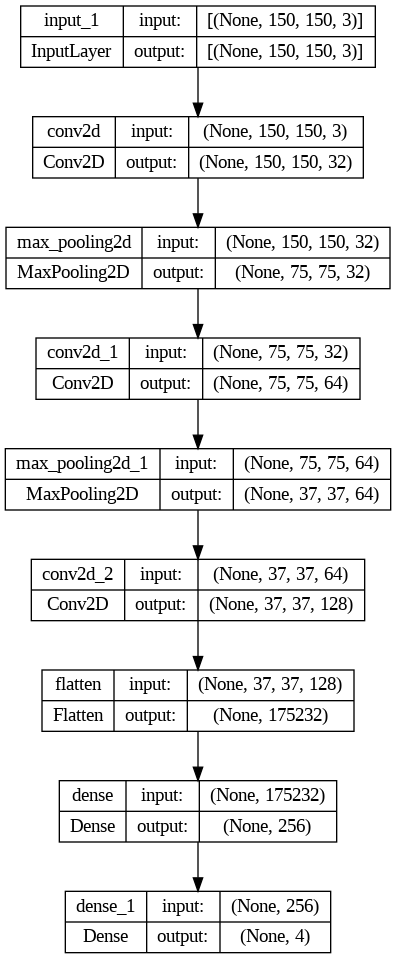

In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Assuming you have already defined the random_cnn function and created the model

# Plot the model architecture to a file
plot_model(random_model, to_file='random_cnn_model.png', show_shapes=True)



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils import plot_model

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
#Splitting the data into train, test, and validation sets
#Veriyi train, test ve validation olarak ayıralım
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
import tensorflow as tf
# Compiling the model
random_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history = random_model.fit(train_data, train_labels, epochs=40, batch_size=8, validation_data=(test_data, test_labels))

Epoch 1/40
1282/1282 [==============================] - 36s 24ms/step - loss: 0.7280 - accuracy: 0.6809 - val_loss: 0.4646 - val_accuracy: 0.7964
Epoch 2/40
1282/1282 [==============================] - 29s 23ms/step - loss: 0.2869 - accuracy: 0.8894 - val_loss: 0.3221 - val_accuracy: 0.8935
Epoch 3/40
1282/1282 [==============================] - 30s 23ms/step - loss: 0.1222 - accuracy: 0.9564 - val_loss: 0.2284 - val_accuracy: 0.9189
Epoch 4/40
1282/1282 [==============================] - 29s 23ms/step - loss: 0.0496 - accuracy: 0.9836 - val_loss: 0.1977 - val_accuracy: 0.9462
Epoch 5/40
1282/1282 [==============================] - 28s 22ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.2494 - val_accuracy: 0.9345
Epoch 6/40
1282/1282 [==============================] - 28s 22ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.1994 - val_accuracy: 0.9473
Epoch 7/40
1282/1282 [==============================] - 28s 22ms/step - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.3498 -

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Making predictions on the testing data
y_pred_probs = random_model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converting one-hot encoded labels back to categorical labels
y_true = np.argmax(test_labels, axis=1)

# Calculating accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculating precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculating recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculating F1-score
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


81/81 [==============================] - 2s 13ms/step
Accuracy: 0.968408736349454
Precision: 0.9682823625541024
Recall: 0.968408736349454
F1-score: 0.968305860899416


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extracting TP, TN, FP, FN from the confusion matrix
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("Confusion Matrix:")
print(conf_matrix)


True Positives: 633
True Negatives: 634
False Positives: 0
False Negatives: 0
Confusion Matrix:
[[634   0   2   4]
 [  0 633   0   0]
 [  5   0 640  27]
 [ 12   1  30 576]]


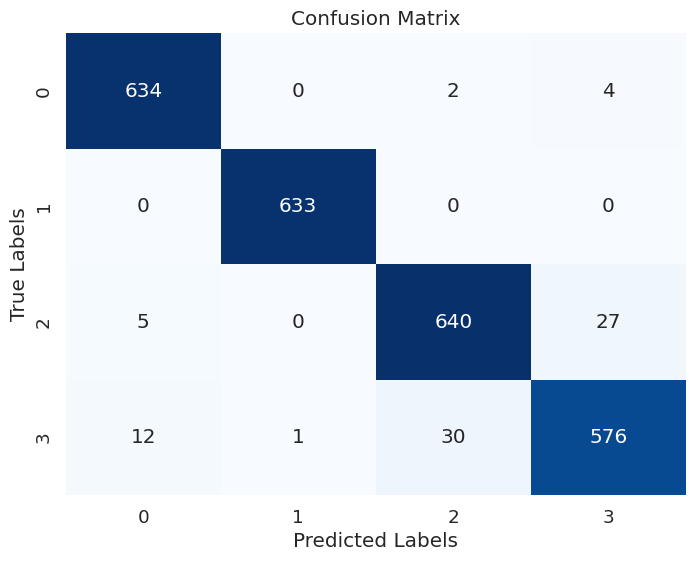

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Creating a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
